# Isolation Forest

In [1]:
# Exécutez cette cellule pour charger les modules nécessaires 
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, classification_report, make_scorer, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler


In [2]:

df = pd.read_csv('creditcard.csv')


 ## Modifier les labels 1 de la variable Class en -1 et les labels 0 en 1.

In [3]:
# les algorithme de détection preinnent par convention le label -1 pour les outliers et 1 pour les inliers
df['Class'].replace({1: -1}, inplace=True)
df['Class'].replace({0: 1}, inplace=True)

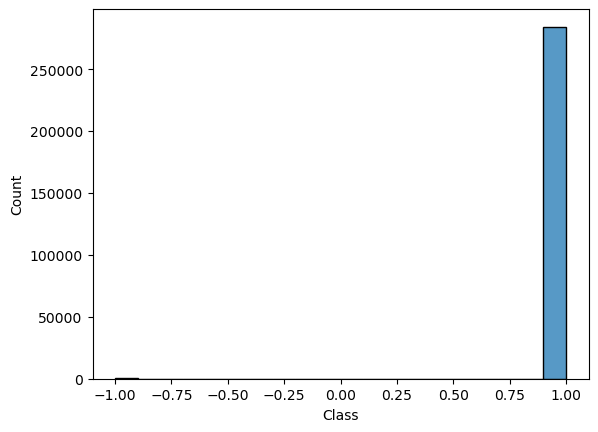

In [5]:
target = df['Class']
sns.histplot(target);


## on ne va prendre qu'une partie des données.

(20000, 31)
(492, 31)
(20492, 31)


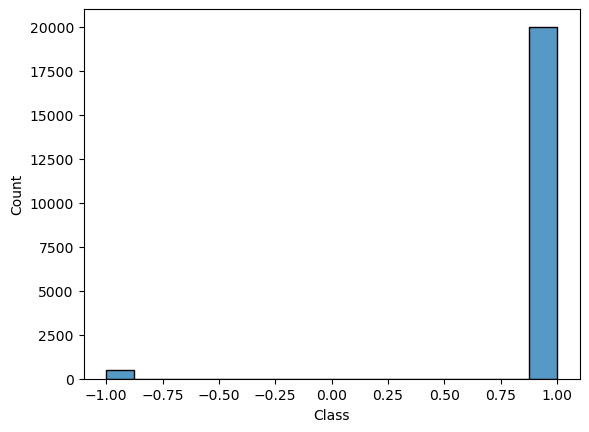

In [7]:
#Réduire la taille de df_inliers aux 20000 premières données.
df_inliers = df[df['Class']==1]
df_outliers = df[df['Class']==-1]

df_inliers = df_inliers[:20000]

#Concaténer df_inliers et df_outliers dans un DataFrame df.

df = pd.concat([df_inliers, df_outliers])
target = df['Class']

print(df_inliers.shape)
print(df_outliers.shape)
print(df.shape)

sns.histplot(target);


### la proportion d'outliers dans le jeu de données

In [78]:
# la proportion d'outliers dans le jeu de données
pourcentage= df[df['Class']==-1]['Class'].count()/df['Class'].count()
pourcentage

0.024009369510052704

### Séparer le jeu de données en un échantillon d'apprentissage et de test

In [25]:
# on va respecter la proportion de 20% des données test.

X_train, X_test, y_train, y_test= train_test_split(df, target, test_size=0.2)
X_train = X_train.drop('Class', axis = 1)
X_test = X_test.drop('Class', axis = 1)


In [27]:

isof = IsolationForest(contamination=0.03, n_estimators=100, n_jobs=-1)


In [31]:
isof.fit(X_train)

y_pred = isof.predict(X_test)



C:\Users\Utilisateur\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [32]:
from sklearn.metrics import classification_report, confusion_matrix
conf_matrix=confusion_matrix(y_test, y_pred)
conf_matrix

array([[  67,   36],
       [  47, 3949]], dtype=int64)

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.59      0.65      0.62       103
           1       0.99      0.99      0.99      3996

    accuracy                           0.98      4099
   macro avg       0.79      0.82      0.80      4099
weighted avg       0.98      0.98      0.98      4099



In [35]:
# On découpe manuellement nos jeu de données de validation croisée au sein de l'échantillon d'apprentissage
skf = StratifiedKFold(n_splits=3) 
folds = list(skf.split(X_train, y_train))
forest = IsolationForest()

# Dans la situation où on ne connait pas à priori le paramètre de contamination,
# on ajoutera la contamination dans la grille de recherche

resc = make_scorer(recall_score,pos_label=-1)

params = {'contamination': np.linspace(0.01, 0.05, 10), 'n_estimators': [100,200,300]}

search = GridSearchCV(estimator=forest, param_grid=params, scoring=resc, cv=folds, n_jobs=-1)
search.fit(X_train, y_train)

# predict
optimal_forest = search.best_estimator_
y_pred = optimal_forest.predict(X_test)


pd.crosstab(y_test, y_pred, rownames=['Classes réelles'], colnames=['Classes prédites'])

C:\Users\Utilisateur\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Classes prédites,-1,1
Classes réelles,,
-1,78,25
1,94,3902


In [36]:
conf_matrix=confusion_matrix(y_test, y_pred)
conf_matrix

array([[  78,   25],
       [  94, 3902]], dtype=int64)

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.45      0.76      0.57       103
           1       0.99      0.98      0.98      3996

    accuracy                           0.97      4099
   macro avg       0.72      0.87      0.78      4099
weighted avg       0.98      0.97      0.97      4099



# One class SVM

### On sélectionne uniquement les labels qui correspondent à 1

In [39]:
# il faut s'assurer que les données soient le moins polluées par des outliers
y_inliers = y_train[y_train.values==1]

# On crée une liste d'index pour pouvoir récupérer les variables explicatives de ces index
liste = list(y_inliers.index.values)


### On récupère ces variables explicatives dans un nouveau DataFrame

In [55]:
# On récupère ces variables explicatives dans un nouveau DataFrame pour lesquel on a retire 300+ outliers
X_train_inliers = X_train.loc[liste]

len(X_train),len(X_train_inliers)

(16393, 16004)

### on va standardiser les donnés

In [40]:
# Création de l'objet Scaler
scaling = MinMaxScaler(feature_range=(-1, 1)).fit(X_train_inliers)

# Entrainement du scaler à partir du dataset utilisé dans la phase d'apprentissage
X_train_inliers = scaling.transform(X_train_inliers)

# On transforme X_test avec les informations du DataFrame d'apprentissage
X_test = scaling.transform(X_test)

### On définit l'objet OneClassSVM

In [41]:
# On définit l'objet OneClassSVM
clf_osvm = svm.OneClassSVM(kernel='rbf', nu=0.005, gamma='scale')

# Entrainement du modèle
clf_osvm.fit(X_train_inliers)

OneClassSVM(nu=0.005)

### Prédiction

In [77]:
# Prédiction à partir des variables explicatives de l'échantillon de test
y_pred = clf_osvm.predict(X_test)
y_train_pred = clf_osvm.predict(X_train_inliers)

# Affichage des résultats sous la forme d'une matrice de confusion
pd.crosstab(y_train, y_train_pred, rownames=['Classes réelles'], colnames=['Classes prédites'])
# Affichage des résultats sous la forme d'une matrice de confusion
pd.crosstab(y_test, y_pred, rownames=['Classes réelles'], colnames=['Classes prédites'])
pd.crosstab(y_train, y_train_pred, rownames=['Classes réelles'], colnames=['Classes prédites'])

(Classes prédites  -1     1
 Classes réelles           
 -1                97     5
  1                17  3980,
 Classes prédites  -1      1
 Classes réelles            
 -1                61      0
  1                 0  11933)

In [72]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.85      0.95      0.90       102
           1       1.00      1.00      1.00      3997

    accuracy                           0.99      4099
   macro avg       0.92      0.97      0.95      4099
weighted avg       1.00      0.99      0.99      4099

